# Outcome constraints in Bayesian optimization

In optimization, it is often the goal that we need to optimize an objective function while satisfying some constraints. For example, we may want to minimize the scrap rate by finding the optimal process parameters of an manufacturing machine. However, we know the scrap rate cannot be below 0. In another setting, we may want to maximize the throughput of a machine, but we know that the throughput cannot exceed the maximum belt speed of the machine. Thus, we need to find regions in the search space that both yield high objective values and satisfy these constraints. In this blog, we will focus on inequality _outcome constraints_. That is, the domain of the objective function is 

$$\text{lower} \le f(x) \le \text{upper}$$

where $\text{lower}$ and $\text{upper}$ are the lower and upper bounds of the objective function. You need not both bounds, but rather one or the other. The set of points $x'$ that satisfy the constraint are called _feasible points_ and the set of points that do not satisfy the constraint are called _infeasible points_. Often, in tutorials and or books teaching Bayesian optimization, it is assumed we know a cost function a priori that restricts the outcome space in some way and use an additional model to model the constraint. However, in practice, we often only know a lower and or upper bound according to technical specifications, and this does not require an additional model. In this blog, we will show how to use BoTorch to optimize a one-dimensional function with an outcome constraint. The remainder of the post assumes you already have knowledge about Bayesian optimization.

## Probability of feasibility

In BoTorch it is common to use a Gaussian Process (GP) to model the objective function. The output of the GP is a Gaussian distribution over the predicted values for a given set of input points. It provides not just a single point estimate but a probabilistic prediction that accounts for uncertainty in the predictions. Thus, for each point in the search space, we have a corresponding Gaussian distribution representing the belief of the objective value at that point.

Intuitively, if we have defined an outcome constraint, we can compute the probability that $f(x)$ is feasible by taking the cumulative distribution function (CDF) of the predictive distribution and computing the area between the lower bound and the upper bound.

## Constrained Policy

With the probability of feasibility computed, we can scale the policy, e.g. expected improvement (EI), score of each unseen point in the search space by the probability the point is feasible.  
- if the data point is likely to satisfy the constraints, then its EI score will be multiplied by a large number (a high probability of feasibility), thus keeping the EI score high.
- if the data point is unlikely to satisfy the constraints, then its EI score will be multiplied by a small number (a small probability of feasibility), thus keeping the EI score small.

This is called a _constrained policy_, and BoTorch offers most of the common policies with a constrained version.

## Implementation

To implement...

In [1]:
#| code-fold: true
import matplotlib.pyplot as plt
import torch

from botorch.acquisition import qLogExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

plt.style.use("https://raw.githubusercontent.com/GStechschulte/filterjax/main/docs/styles.mplstyle")

In [2]:
def objective_fn(x):
    return -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3

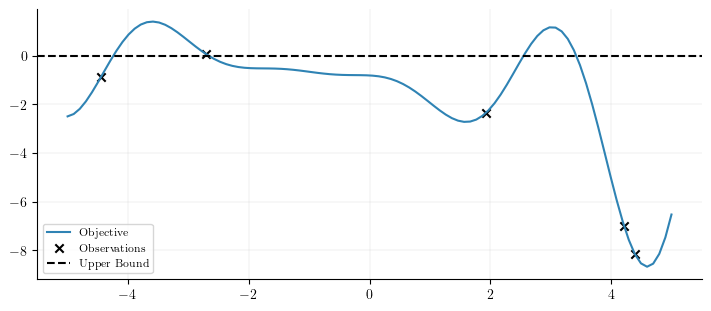

In [8]:
lb, ub = -5, 5
bounds = torch.tensor([[lb], [ub]], dtype=torch.float)
xs = torch.linspace(lb, ub, 100).unsqueeze(1)
ys = -objective_fn(xs)

n = 5
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n, 1, dtype=torch.double)
train_y = -objective_fn(train_x)

plt.figure(figsize=(7, 3))
plt.plot(xs, ys, label="Objective")
plt.scatter(train_x, train_y, color="black", label="Observations")
plt.axhline(y=0, color="k", linestyle="--", label="Upper Bound")
plt.legend();

In [ ]:
n_iterations = 20
upper = 0.
for iteration in range(n_iterations):
    print(f"iter: {iteration}")

    model = SingleTaskGP(train_x, train_y, )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    logEI = qLogExpectedImprovement(
        model, 
        best_f=train_y[train_y < 0].max(), 
        constraints=[
            lambda Z: Z.squeeze(-1) - upper
            # lambda Z: lower - Z.squeeze(-1),
        ]
    )

    new_x, _ = optimize_acqf(
        acq_function=logEI,
        bounds=bounds,
        q=1,  
        num_restarts=5,
        raw_samples=20,
    )

    new_y = -objective_fn(new_x)

    train_x = torch.cat([train_x, new_x])
    train_y = torch.cat([train_y, new_y])

In [10]:
with torch.no_grad():
    predictive_dist = model.likelihood(model(xs))
    acquisition_score = logEI(xs.unsqueeze(1))

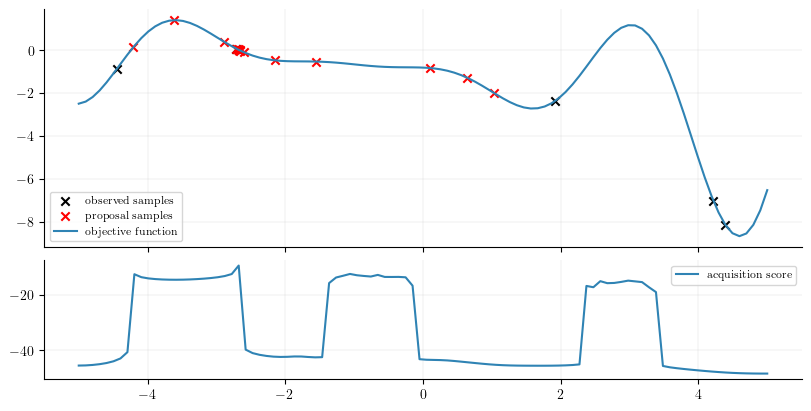

In [11]:
fig, ax = plt.subplots(
    2, 1, 
    figsize=(8, 4), 
    sharex=True, 
    gridspec_kw={"height_ratios": [2, 1]}
)

ax[0].scatter(train_x[:5], train_y[:5], color="black", label="observed samples")
ax[0].scatter(train_x[5:], train_y[5:], color="red", label="proposal samples")
ax[0].plot(xs, ys, label="objective function")
ax[0].legend()

ax[1].plot(xs, acquisition_score, label="acquisition score")
ax[1].legend();

Notice how the majority of the proposed points are around $x=2.5$ with an objective value less than zero.